<a href="https://colab.research.google.com/github/BenRoche18/Im2Calories/blob/master/food_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import packages**

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import shutil

**Declare parameters**

In [29]:
FOOD101_DIR = "food-101"
TRAIN_DIR = os.path.join(FOOD101_DIR, "train")
VAL_DIR = os.path.join(FOOD101_DIR, "test")
MODEL_PATH = os.path.join("models", "food_classifier", '1')
LOG_DIR = os.path.join("logs", "fits", "food_classifier", '1')

IMAGE_SIZE = 244

BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cpu


**Download Food101 dataset**


In [0]:
if "food-101" not in os.listdir():
  print("Downloading Food-101 dataset... ", end="")
  !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
  print("Done")
  print("Extracting data... ", end="")
  !tar xzvf food-101.tar.gz
  print("Done")

**Split dataset into training and validation images**

In [0]:
images = {}

for split in ["train", "test"]:
  # extract image filenames
  with open(os.path.join(FOOD101_DIR, "meta", split+".txt"), 'r') as file:
    for path in file.readlines():
      path = path.strip()
      food_class, food_id = path.split('/')
      images.setdefault(food_class, []).append(food_id)

  # copy images into split directory
  for food_class in images.keys():
    # make class directory
    #os.makedirs(os.path.join(FOOD101_DIR, split, food_class))

    # populate class directory with images
    for food_id in images[food_class]:
      src = os.path.join(FOOD101_DIR, "images", food_class, food_id+".jpg")
      dest = os.path.join(FOOD101_DIR, split, food_class, food_id+".jpg")
      shutil.copy(src, dest)

  images = {}

**Fetch training images**

In [0]:
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_raw = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
train_size = len(train_raw)

train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True)

class_names = train_raw.classes

**Fetch validation images**

In [0]:
val_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_raw = torchvision.datasets.ImageFolder(VAL_DIR, transform=val_transform)
val_size = len(val_raw)

val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE)

**Show example images from dataset**

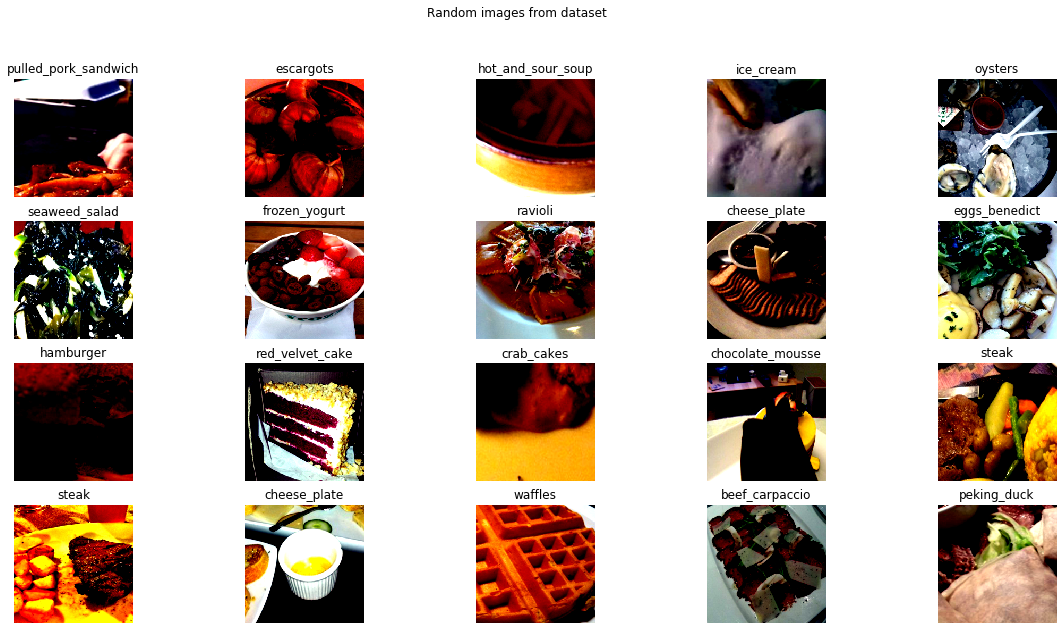

In [24]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Random images from dataset")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  j = np.random.randint(train_size)
  img = train_raw[j][0].numpy()
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  plt.title(class_names[train_raw[j][1]])
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
plt.show()

**Fetch Model**

In [25]:
# fetch pre-trained feature extractor
model = torchvision.models.resnet18(pretrained=True)

# freeze feature extractor
for param in model.parameters():
  param.requires_grad = False

# extract number of features that are outputted in base model
num_features = model.fc.in_features

# replace classification head with 101-way dense layer
model.fc = torch.nn.Linear(num_features, 101)



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


**Declare training functions**

In [0]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)
loss_func = torch.nn.CrossEntropyLoss()

**Train model**

In [0]:
best_acc = 0.0
best_model_weights = None

print("Training on {} images...\n".format(train_size))

for epoch in range(1, EPOCHS+1):
  print("Epoch {}/{}...".format(epoch, EPOCHS))

  ### TRAINING PHASE ###
  model.train()
  running_loss = 0.0
  running_corrects = 0

  for (images, labels) in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    # reset the parameter gradients
    optimizer.zero_grad()

    # fit images on model
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    loss = loss_func(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(predictions == labels.data)

    # calculate statistics
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size


  ### VALIDATION PHASE ###
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  for (images, labels) in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    # fit images on model
    with torch.no_grad():
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      loss = loss_func(outputs, labels)

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(predictions == labels.data)

  # calculate statistics
  val_loss = running_loss / val_size
  val_acc = running_corrects.double() / val_size

	# save best model seen
  if val_acc > best_acc:
    best_acc = epoch_acc
    best_model_weights = copy.deepcopy(model.state_dict())

	# print statistics
  print("Training Loss: {:.4f}, Acc: {:.4f}".format(epoch_loss, epoch_acc))
  print("Validation Loss: {:.4f}, Acc: {:.4f}\n".format(val_loss, val_acc))

# reinstantiate best seen weights
model.load_state_dict(best_model_weights)

print("DONE")

Training on 75750 images...

Epoch 1/10...
